In [ ]:
import numpy as np
import pandas as pd

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from pickle import dump as save
from pickle import load as download

In [ ]:
def decoder_npy(path):
    data = np.load(path, allow_pickle=True)
    d = dict(enumerate(data.flatten(), 1))
    
    return d[1]

In [ ]:
def make_working_set(data, targets):
    out = []
    y = []

    for i in data.keys():
        out.append(data[i]['emb'])
        y.append(data[i]['target'])

    y = np.array(y)

    for i in targets.keys():
        y[y == i] = targets[i]

    return np.array(out), y.astype('int')

In [ ]:
dict_tar = {'anger': 0, 'disgust': 1, 'fear': 2, 'sadness': 3, 'neutral': 4, 
            'joy': 5, 'surprise': 6}

In [ ]:
def cm_plot(y_test, y_pred, y_type):

    cm = confusion_matrix(y_test, y_pred)
    # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(cmn, cmap='Blues', annot=True, fmt='.2f')
    sns.set(font_scale=1.3)
    plt.title(f'Confusion Matrix of {y_type}')

    return plt.show()

In [ ]:
def statistic(y_pred_test, y_test, y_pred_train, y_train):
    score_table = pd.DataFrame(columns=('train', 'test'))

    b_train = balanced_accuracy_score(y_train, y_pred_train)
    b_test = balanced_accuracy_score(y_test, y_pred_test)
    score_table.loc['balanced_accuracy_score', :] = (b_train, b_test)

    a_train = accuracy_score(y_train, y_pred_train)
    a_test = accuracy_score(y_test, y_pred_test)
    score_table.loc['accuracy_score', :] = (a_train, a_test)

    f1_train = f1_score(y_train, y_pred_train, average='weighted')
    f1_test = f1_score(y_test, y_pred_test, average='weighted')
    score_table.loc['f1 weighted', :] = (f1_train, f1_test)

    f1_train = f1_score(y_train, y_pred_train, average='micro')
    f1_test = f1_score(y_test, y_pred_test, average='micro')
    score_table.loc['f1 micro', :] = (f1_train, f1_test)

    f1_train = f1_score(y_train, y_pred_train, average='macro')
    f1_test = f1_score(y_test, y_pred_test, average='macro')
    score_table.loc['f1 macro', :] = (f1_train, f1_test)

    return score_table

In [ ]:
train_vector_ss = decoder_npy('/kaggle/input/model-early-fusion/train_ss_trained_pooler.npy')
test_vector_ss = decoder_npy('/kaggle/input/model-early-fusion/test_ss_trained_pooler.npy')
dev_vector_ss = decoder_npy('/kaggle/input/model-early-fusion/dev_ss_trained_pooler.npy')

X_train, y_train = make_working_set(train_vector_ss, dict_tar)
X_dev, y_dev = make_working_set(dev_vector_ss, dict_tar)
X_test, y_test = make_working_set(test_vector_ss, dict_tar)

In [ ]:
train_vector = train_vector_ss.copy()
for i in dev_vector_ss.keys():
    train_vector[i + '_dev'] = dev_vector_ss[i]
    
X_train_td, y_train_td = make_working_set(train_vector, dict_tar)

In [ ]:
from pickle import load as download

f = open('/kaggle/input/model-early-fusion/SVC_model_61_57score_pooler_768.pickle', 'rb')
classifier = download(f)
f.close

<function BufferedReader.close>

In [ ]:
from sklearn.metrics import recall_score

def count_uar(y_test, y_pred, **kwargs):
    return recall_score(y_test, y_pred, average='macro') 

In [ ]:
from sklearn.metrics import make_scorer

scoring = make_scorer(count_uar, greater_is_better=True)

In [ ]:
def objective(trial):
    global X_train_td, y_train_td, scoring

    c = trial.suggest_float("svc_c", 1e-1, 1e2, log=True)

    clf = sklearn.svm.SVC(C=c, random_state=3, class_weight='balanced')

    score = sklearn.model_selection.cross_val_score(clf, X_train_td, y_train_td, 
                                                    cv=3, scoring=scoring)
    uar = score.mean()
    return uar


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)
print(study.best_trial)

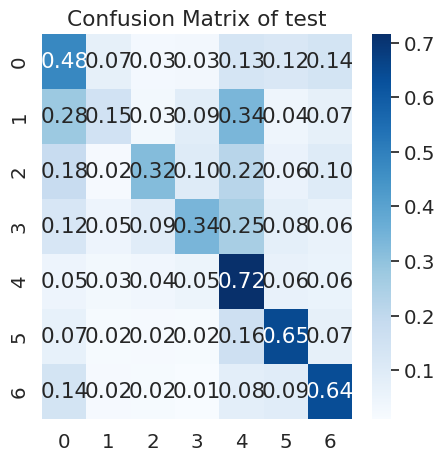

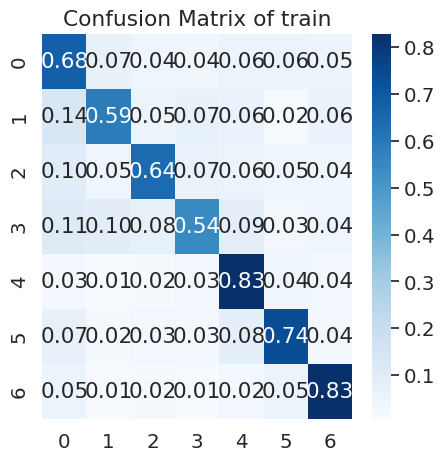

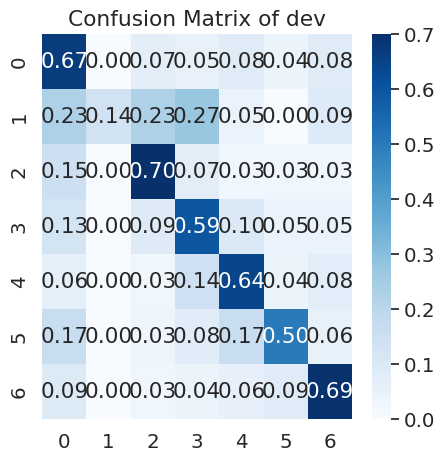

              precision    recall  f1-score   support

           0       0.48      0.48      0.48       345
           1       0.11      0.15      0.12        68
           2       0.15      0.32      0.21        50
           3       0.42      0.34      0.38       208
           4       0.80      0.72      0.76      1256
           5       0.61      0.65      0.63       402
           6       0.51      0.64      0.57       281

    accuracy                           0.61      2610
   macro avg       0.44      0.47      0.45      2610
weighted avg       0.64      0.61      0.62      2610



,train,test
balanced_accuracy_score,0.692083,0.469572
accuracy_score,0.762999,0.61341
f1 weighted,0.770736,0.622541
f1 micro,0.762999,0.61341
f1 macro,0.649719,0.448264


In [ ]:
from sklearn import metrics #pooler 768 0.47
classifier = sklearn.svm.SVC(C=xxx, random_state=3)

classifier.fit(X_train_td, y_train_td)

y_pred = classifier.predict(X_test)
y_train_pred = classifier.predict(X_train_td)
y_train_dev = classifier.predict(X_dev)

cm_plot(y_test, y_pred, 'test')
cm_plot(y_train_td, y_train_pred, 'train')
cm_plot(y_dev, y_train_dev, 'dev')

print(metrics.classification_report(y_test, y_pred))

statistic(y_pred, y_test, y_train_pred, y_train_td)

In [ ]:
from pickle import dump as _save_

f = open('SVC_model_61_26score_pooler_768.pickle', 'wb')
_save_(classifier, f)
f.close()